<a href="https://colab.research.google.com/github/SeongjiGo/Noise_Reduction_with_Autoencoder/blob/master/noise_Reduction_with_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# similar Image classifier


Data Load


In [2]:
import os
from glob import glob
import pandas as pd

file_path = './drive/MyDrive/Similar_image_classifier/dataSet/*/*.png'
file_list = glob(file_path)

data_dict = {'image_name':[], 'file_path':[]}

for path in file_list:
    data_dict['file_path'].append(path)

    path_list = path.split(os.path.sep)
    data_dict['image_name'].append(path_list[-1])

train_df = pd.DataFrame(data_dict)
train_df.to_csv("./drive/MyDrive/Similar_image_classifier/train.csv", mode='w')
print('csv파일 생성완료! ')

from sklearn.model_selection import train_test_split

def get_df():
    df = pd.read_csv("./drive/MyDrive/Similar_image_classifier/train.csv")
    print('csv 읽기 완료!')
    df_train, df_val = train_test_split(df, test_size=0.1)
    return df_train, df_val

df_train, df_val = get_df()
print(f'trainNum: {len(df_train)}, valNum: {len(df_val)}')

import torch
from torch.utils.data import Dataset
from PIL import Image

class Classification_Dataset(Dataset):
    def __init__(self, csv, mode, transform=None):
        self.csv = csv.reset_index(drop=True) # random으로 섞인 데이터의 인덱스를 reset 시켜서 다시 부여한다.
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0] # csv 파일의 행 개수 == 데이터 개수

    def __getitem__(self, index):
        row = self.csv.iloc[index] # 주어진 index에 대한 데이터 뽑아오기
        image = Image.open(row.file_path).convert('RGB') # 파일 경로로 부터 이미지를 읽고 rgb로 변환하기
        if self.transform:
            image = self.transform(image) # 이미지에 transform 적용하기

        return image, image # 하나는 모델에 대한 입력, 하나는 재구성을 위해 원본 이미지와 비교하기 위함

from torchvision import transforms
transform_ = transforms.Compose([
                                 transforms.Resize(224),
                                transforms.ToTensor() ])

transform_noise = transforms.Compose([
                                #transforms.ToPILImage(),
                                 transforms.Resize(224),
                                transforms.ToTensor() ])
dataset_train = Classification_Dataset(df_train, 'train', transform=transform_)
dataset_val = Classification_Dataset(df_val, 'val', transform=transform_)

from torch.utils.data.sampler import RandomSampler
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=0, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=4, shuffle=True, num_workers = 0)

print("데이터 로더 완료")

csv파일 생성완료! 
csv 읽기 완료!
trainNum: 270, valNum: 30
데이터 로더 완료


encoder + decoder class


In [3]:

import torch
import torch.nn as nn
class Encoder(nn.Module):
    """
    A simple Convolutional Encoder Model
    """

    def __init__(self):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))   # 224
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d((2, 2))                    # 112

        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))  
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d((2, 2))                    # 56

        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))  
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2))                    # 28

        # self.conv4 = nn.Conv2d(64, 128, (3, 3), padding=(1, 1)) 
        # self.relu4 = nn.ReLU(inplace=True)
        # self.maxpool4 = nn.MaxPool2d((2, 2))                    # 14

        # self.conv5 = nn.Conv2d(128, 256, (3, 3), padding=(1, 1))
        # self.relu5 = nn.ReLU(inplace=True)
        # self.maxpool5 = nn.MaxPool2d((2, 2))                    # 7

    def forward(self, x):
        # Downscale the image with conv maxpool etc.
        # print(f"decoder - 0Layer shape: {x.shape}")
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # print(f"decoder - 1Layer shape: {x.shape}")
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # print(f"decoder - 2Layer shape: {x.shape}")
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        # # print(f"decoder - 3Layer shape: {x.shape}")
        # x = self.conv4(x)   
        # x = self.relu4(x)
        # x = self.maxpool4(x)

        # # print(f"decoder - 4Layer shape: {x.shape}")
        # x = self.conv5(x)
        # x = self.relu5(x)
        # x = self.maxpool5(x)
        
        # print(f"decoder - 5Layer shape: {x.shape}")
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # self.deconv1 = nn.ConvTranspose2d(256, 128, (2, 2), stride=(2, 2))
        # self.relu1 = nn.ReLU(inplace=True)

        # self.deconv2 = nn.ConvTranspose2d(128, 64, (2, 2), stride=(2, 2))
        # self.relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
        self.relu3 = nn.ReLU(inplace=True)

        self.deconv4 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2))
        self.relu4 = nn.ReLU(inplace=True)

        self.deconv5 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
        self.relu5 = nn.ReLU(inplace=True)

    def forward(self, z):
         # Upscale the image with convtranspose etc.
        # z = self.deconv1(z)
        # z = self.relu1(z)

        # z = self.deconv2(z)
        # z = self.relu2(z)

        z = self.deconv3(z)
        z = self.relu3(z)

        z = self.deconv4(z)
        z = self.relu4(z)

        z = self.deconv5(z)
        z = self.relu5(z)
        return z


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


class Autoencoder(pl.LightningModule):
    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3,
                 width: int = 224,
                 height: int = 224):
        super().__init__()
        self.encoder = encoder_class()
        self.decoder = decoder_class()


    def forward(self, data):
        z = self.encoder(data)
        reData = self.decoder(z)
        return reData

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
decoder = Decoder().to(device)

parameters = list(encoder.parameters()) + list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr = 2e-4)



In [6]:
from tqdm import tqdm

for i in range(30):
    for j,[image,label] in enumerate(tqdm(train_loader)) :
        optimizer.zero_grad()
        image = image.to(device)

        output = encoder(image)
        output = decoder(output)

        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()

    
    print(f'Epochs: {i} MSELoss: {loss}')

100%|██████████| 67/67 [02:25<00:00,  2.17s/it]


Epochs: 0 MSELoss: 0.1419469118118286


100%|██████████| 67/67 [00:04<00:00, 16.17it/s]


Epochs: 1 MSELoss: 0.05940527841448784


100%|██████████| 67/67 [00:03<00:00, 22.33it/s]


Epochs: 2 MSELoss: 0.031060798093676567


100%|██████████| 67/67 [00:02<00:00, 22.60it/s]


Epochs: 3 MSELoss: 0.024021025747060776


100%|██████████| 67/67 [00:03<00:00, 22.05it/s]


Epochs: 4 MSELoss: 0.00852100271731615


100%|██████████| 67/67 [00:02<00:00, 22.34it/s]


Epochs: 5 MSELoss: 0.0067029306665062904


100%|██████████| 67/67 [00:02<00:00, 22.56it/s]


Epochs: 6 MSELoss: 0.008329064585268497


100%|██████████| 67/67 [00:03<00:00, 22.32it/s]


Epochs: 7 MSELoss: 0.006787519436329603


100%|██████████| 67/67 [00:02<00:00, 22.74it/s]


Epochs: 8 MSELoss: 0.008670532144606113


100%|██████████| 67/67 [00:02<00:00, 22.48it/s]


Epochs: 9 MSELoss: 0.006311357952654362


100%|██████████| 67/67 [00:02<00:00, 22.62it/s]


Epochs: 10 MSELoss: 0.006905354559421539


100%|██████████| 67/67 [00:02<00:00, 22.68it/s]


Epochs: 11 MSELoss: 0.004631787538528442


100%|██████████| 67/67 [00:02<00:00, 22.64it/s]


Epochs: 12 MSELoss: 0.0055241333320736885


100%|██████████| 67/67 [00:02<00:00, 22.60it/s]


Epochs: 13 MSELoss: 0.0034445442724972963


100%|██████████| 67/67 [00:02<00:00, 22.70it/s]


Epochs: 14 MSELoss: 0.004262727685272694


100%|██████████| 67/67 [00:02<00:00, 22.89it/s]


Epochs: 15 MSELoss: 0.0038681235164403915


100%|██████████| 67/67 [00:02<00:00, 22.43it/s]


Epochs: 16 MSELoss: 0.0030145265627652407


100%|██████████| 67/67 [00:02<00:00, 22.65it/s]


Epochs: 17 MSELoss: 0.005115220323204994


100%|██████████| 67/67 [00:02<00:00, 22.89it/s]


Epochs: 18 MSELoss: 0.004498644731938839


100%|██████████| 67/67 [00:02<00:00, 22.72it/s]


Epochs: 19 MSELoss: 0.0026117998640984297


100%|██████████| 67/67 [00:02<00:00, 22.37it/s]


Epochs: 20 MSELoss: 0.004337167367339134


100%|██████████| 67/67 [00:03<00:00, 22.28it/s]


Epochs: 21 MSELoss: 0.0030918135307729244


100%|██████████| 67/67 [00:02<00:00, 22.66it/s]


Epochs: 22 MSELoss: 0.003358506364747882


100%|██████████| 67/67 [00:02<00:00, 22.41it/s]


Epochs: 23 MSELoss: 0.0030468031764030457


100%|██████████| 67/67 [00:02<00:00, 22.57it/s]


Epochs: 24 MSELoss: 0.0026958005037158728


100%|██████████| 67/67 [00:02<00:00, 22.84it/s]


Epochs: 25 MSELoss: 0.004770216997712851


100%|██████████| 67/67 [00:02<00:00, 22.48it/s]


Epochs: 26 MSELoss: 0.002647796645760536


100%|██████████| 67/67 [00:02<00:00, 22.50it/s]


Epochs: 27 MSELoss: 0.0027083514723926783


100%|██████████| 67/67 [00:02<00:00, 22.67it/s]


Epochs: 28 MSELoss: 0.002718498930335045


100%|██████████| 67/67 [00:02<00:00, 22.81it/s]

Epochs: 29 MSELoss: 0.0023644245229661465


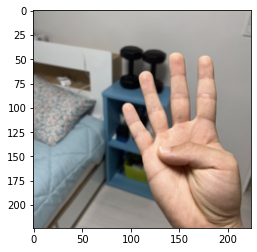

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


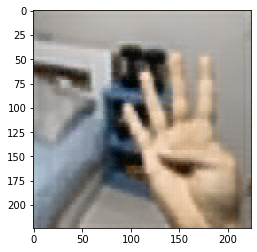

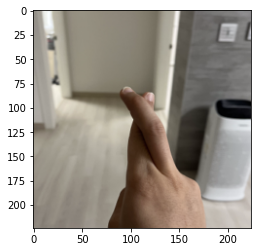

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


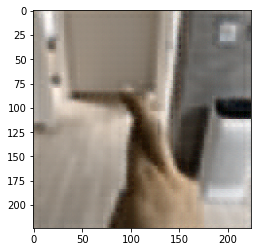

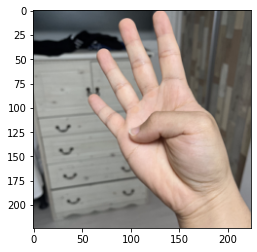

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


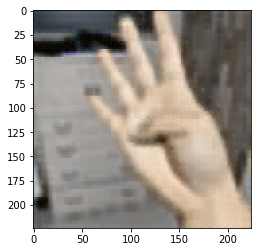

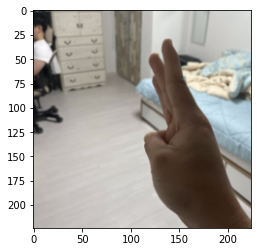

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


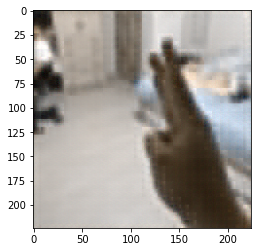

In [7]:
import matplotlib.pyplot as plt
import numpy as np

out_img = torch.squeeze(output.cpu().data)

for i in range(4):
    temp = image[i].cpu()
    plt.imshow(torch.squeeze(np.transpose(temp, (1, 2, 0))))
    plt.show()
    plt.imshow(np.transpose(out_img[i], (1, 2, 0)))
    plt.show()

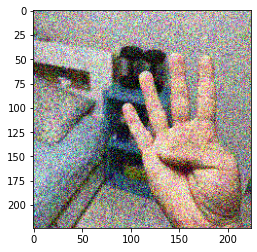

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


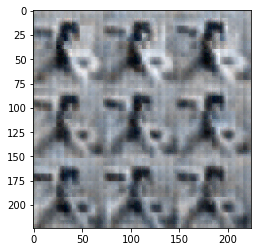

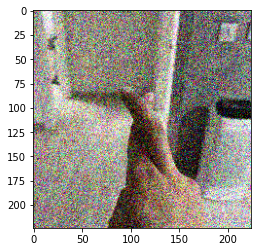

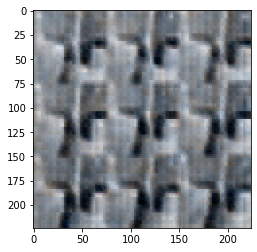

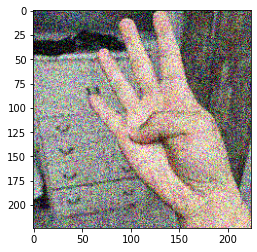

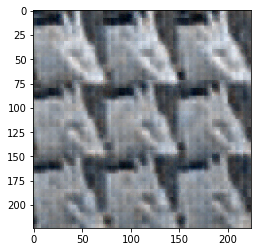

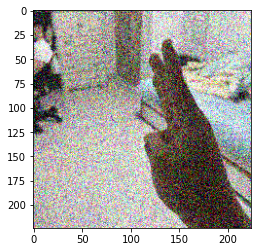

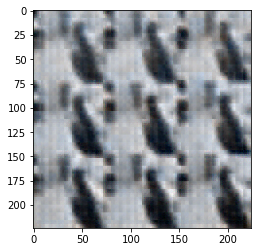

In [11]:
noise_force = 0.2
sample_Image = image[0:]
train_noisy = []

for i in range(len(sample_Image)):
    train_noisy.append(sample_Image[i].cpu().numpy() + noise_force * np.random.normal(loc=0.0, scale=1.0, size=sample_Image[i].shape))

train_noisy = np.clip(train_noisy, 0., 1.) # 0보다 아래인건 0, 1보다 큰건 1

for img in train_noisy:

    plt.imshow(np.transpose(img, (1, 2, 0))) # rgb채널을 1차원으로 변환 (imshow 조건)
    plt.show()
    
    img = img.transpose(1, 2, 0)

    img = Image.fromarray((img * 255).astype(np.uint8))
    img = transform_noise(img)
    
    img = img.view(1, 224, 224, 3)
    img = np.transpose(img, (0, 3, 1, 2))
    img = img.to(device)


    z = encoder(img)
    output = decoder(z)
    output = np.squeeze(output)

    plt.imshow(np.transpose(output.cpu().detach().numpy(), (1, 2, 0)))
    plt.show()